# Lab 5: Encoding Models of Retinal Ganglion Cells

**STATS320: Machine Learning Methods for Neural Data Analysis**

_Stanford University. Winter, 2021._

---

**Team Name:** Team: Team Name

**Team Members:** Collin, Samyak, Tom

*Due: 11:59pm Thursday, Feb 18, 2021 via GradeScope*

---

In this lab, you'll build generalized linear models (GLMs) and convolutional neural network (CNN) models of retinal ganglion cell (RGC) responses to visual stimuli. You'll use PyTorch to implement the models and fit them to a dataset  kindly provided by the [Baccus Lab](https://baccuslab.sites.stanford.edu/) (Stanford University), which they studied in the "Deep Retina" paper [(McIntosh et al, 2016)](https://arxiv.org/abs/1702.01825).

### References
McIntosh, Lane T., Niru Maheswaranathan, Aran Nayebi, Surya Ganguli, and Stephen A. Baccus. “Deep Learning Models of the Retinal Response to Natural Scenes.” Advances in Neural Information Processing (NeurIPS), 2016.

# Environment Setup

In [ ]:
import numpy as np
import h5py
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import trange
from copy import deepcopy
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.distributions import Poisson

# Specify that we want our tensors on the GPU and in float32
device = torch.device('cuda')
dtype = torch.float32

# Helper function to convert between numpy arrays and tensors
to_t = lambda array: torch.tensor(array, device=device, dtype=dtype)
from_t = lambda tensor: tensor.to("cpu").detach().numpy()

In [ ]:
#@title Helper functions for plotting (run this cell!)
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

def plot_stimulus_weights(glm):
    num_neurons = glm.num_neurons
    max_delay = glm.max_delay

    fig, axs = plt.subplots(num_neurons, 3, figsize=(8, 4 * num_neurons), 
                            gridspec_kw=dict(width_ratios=[1, 1.9, .1]))

    temporal_weights = from_t(glm.temporal_conv.weight[:, 0])
    bias = from_t(glm.temporal_conv.bias)
    spatial_weights = from_t(glm.spatial_conv.weight)
    spatial_weights = spatial_weights.reshape(num_neurons, 50, 50)

    # normalize and flip the spatial weights
    for n in range(num_neurons):
        # Flip if spatial weight peak is negative
        if np.allclose(spatial_weights[n].min(), 
                    -abs(spatial_weights[n]).max()):
            spatial_weights[n] = -spatial_weights[n]
            temporal_weights[n] = -temporal_weights[n]

        # Normalize
        scale = np.linalg.norm(spatial_weights[n])
        spatial_weights[n] /= scale
        temporal_weights[n] *= scale

    # Set the same limits for each neuron
    vlim = abs(spatial_weights).max()
    ylim = abs(temporal_weights).max()
    
    for n in range(num_neurons):
        axs[n, 0].plot(np.arange(-max_delay+1, 1) * 10, temporal_weights[n])
        axs[n, 0].set_ylim(-ylim, ylim)
        axs[n, 0].plot(np.arange(-max_delay+1, 1) * 10, np.zeros(max_delay), ':k')
        if n < num_neurons - 1:
            axs[n, 0].set_xticklabels([])
        else:
            axs[n, 0].set_xlabel("$\Delta t$ [ms]")

        im = axs[n, 1].imshow(spatial_weights[n], 
                              vmin=-vlim, vmax=vlim, cmap="RdBu")
        axs[n, 1].set_axis_off()
        axs[n, 1].set_title("neuron {}".format(n + 1))
        plt.colorbar(im, cax=axs[n, 2])


def plot_coupling_weights(glm):
    # Get the weights and flip them to get time after spike
    W = from_t(glm.coupling_conv.weight)
    W = W[:, :, ::-1]
    wlim = abs(W).max()
    dt = 10 * np.arange(W.shape[2])

    fig, axs = plt.subplots(num_neurons, num_neurons, figsize=(12, 12), 
                            sharex=True, sharey=True)
    for i in range(num_neurons):
        for j in range(num_neurons):
            axs[i, j].plot(dt, 0 * dt, ':k')
            axs[i, j].plot(dt, W[i, j])
            axs[i, j].set_ylim(-wlim, wlim)
            axs[i, j].set_title("${} \\to {}$".format(j, i))

            if i == num_neurons - 1:
                axs[i, j].set_xlabel("$\Delta t$ [ms]")
    plt.tight_layout()

def plot_cnn_subunits_1(cnn):
    num_subunits = cnn.num_subunits_1
    max_delay = cnn.max_delay

    fig, axs = plt.subplots(num_subunits, 3, figsize=(8, 4 * num_subunits), 
                            gridspec_kw=dict(width_ratios=[1, 1.9, .1]))

    temporal_weights = from_t(cnn.temporal_conv.weight[:, 0])
    bias = from_t(cnn.temporal_conv.bias)
    spatial_weights = from_t(cnn.spatial_conv.weight)
    spatial_weights = spatial_weights[:, 0, :, :]

    # normalize and flip the spatial weights
    for n in range(num_subunits):
        # Flip if spatial weight peak is negative
        if np.allclose(spatial_weights[n].min(), 
                    -abs(spatial_weights[n]).max()):
            spatial_weights[n] = -spatial_weights[n]
            temporal_weights[n] = -temporal_weights[n]

        # Normalize
        scale = np.linalg.norm(spatial_weights[n])
        spatial_weights[n] /= scale
        temporal_weights[n] *= scale

    # Set the same limits for each neuron
    vlim = abs(spatial_weights).max()
    ylim = abs(temporal_weights).max()
    
    for n in range(num_subunits):
        axs[n, 0].plot(np.arange(-max_delay+1, 1) * 10, temporal_weights[n])
        axs[n, 0].set_ylim(-ylim, ylim)
        axs[n, 0].plot(np.arange(-max_delay+1, 1) * 10, np.zeros(max_delay), ':k')
        if n < num_subunits - 1:
            axs[n, 0].set_xticklabels([])
        else:
            axs[n, 0].set_xlabel("$\Delta t$ [ms]")

        im = axs[n, 1].imshow(spatial_weights[n], 
                              vmin=-vlim, vmax=vlim, cmap="RdBu")
        axs[n, 1].set_axis_off()
        axs[n, 1].set_title("subunit 1,{}".format(n + 1))
        plt.colorbar(im, cax=axs[n, 2])

def plot_cnn_subunits2(cnn):
    cnn_filters_2 = from_t(cnn.layer2.weight)

    fig, axs = plt.subplots(cnn.num_subunits_2, 
                            cnn.num_subunits_1,
                            figsize=(4 * cnn.num_subunits_2,
                                    4 * cnn.num_subunits_1),
                            sharex=True, sharey=True)
    vlim = abs(cnn_filters_2).max()
    for i in range(cnn.num_subunits_2):
        for j in range(cnn.num_subunits_1):
            axs[i, j].imshow(cnn_filters_2[i, j], 
                            vmin=-vlim, vmax=vlim, cmap="RdBu")
            
            axs[i, j].set_title('subunit 1,{} $\\to$ 2,{}'.format(j+1,i+1))
            

In [ ]:
#@title Implement `train_model` function (run this cell!)
def train_model(model, 
                train_dataset, 
                val_dataset,
                objective,
                regularizer=None,
                num_epochs=100, 
                lr=0.1,
                momentum=0.9,
                lr_step_size=25,
                lr_gamma=0.9):
    # progress bars
    pbar = trange(num_epochs)
    pbar.set_description("---")
    inner_pbar = trange(len(train_dataset))
    inner_pbar.set_description("Batch")

    # data loaders for train and validation
    train_dataloader = DataLoader(train_dataset, batch_size=1)
    val_dataloader = DataLoader(val_dataset, batch_size=1)
    dataloaders = dict(train=train_dataloader, val=val_dataloader)

    # use standard SGD with a decaying learning rate
    optimizer = optim.SGD(model.parameters(), 
                          lr=lr, 
                          momentum=momentum)
    scheduler = lr_scheduler.StepLR(optimizer, 
                                    step_size=lr_step_size, 
                                    gamma=lr_gamma)
    
    # Keep track of the best model
    best_model_wts = deepcopy(model.state_dict())
    best_loss = 1e8

    # Track the train and validation loss
    train_losses = []
    val_losses = []
    for epoch in pbar:
        for phase in ['train', 'val']:
            # set model to train/validation as appropriate
            if phase == 'train':
                model.train()
                inner_pbar.reset()
            else:
                model.eval()
            
            # track the running loss over batches
            running_loss = 0
            running_size = 0
            for datapoint in dataloaders[phase]:
                stim_t = datapoint['stimulus'].squeeze(0)
                spikes_t = datapoint['spikes'].squeeze(0)
                if phase == "train":
                    with torch.set_grad_enabled(True):
                        optimizer.zero_grad()
                        # compute the model output and loss
                        output_t = model(stim_t, spikes_t)
                        loss_t = objective(output_t, spikes_t)
                        # only add the regularizer in the training phase
                        if regularizer is not None:
                            loss_t += regularizer(model)

                        # take the gradient and perform an sgd step
                        loss_t.backward()
                        optimizer.step()
                    inner_pbar.update(1)
                else:
                    # just compute the loss in validation
                    output_t = model(stim_t, spikes_t)
                    loss_t = objective(output_t, spikes_t)

                assert torch.isfinite(loss_t)
                running_loss += loss_t.item()
                running_size += 1
            
            # compute the train/validation loss and update the best
            # model parameters if this is the lowest validation loss yet
            running_loss /= running_size
            if phase == "train":
                train_losses.append(running_loss)
            else:
                val_losses.append(running_loss)
                if running_loss < best_loss:
                    best_loss = running_loss
                    best_model_wts = deepcopy(model.state_dict())

        # Update the learning rate
        scheduler.step()

        # Update the progress bar
        pbar.set_description("Epoch {:03} Train {:.4f} Val {:.4f}"\
                             .format(epoch, train_losses[-1], val_losses[-1]))
        pbar.update(1)

    # load best model weights
    model.load_state_dict(best_model_wts)

    return np.array(train_losses), np.array(val_losses)

## Load the data

Load the data from the HDF5 file.
- Each file contains a `train` and `test` group.
- Each group contains:
    - `time`: length `frames` array of timestamps
    - `stimulus`: a `frames x 50 x 50` video taken at ~100Hz
    - `response`: a group with
        - `binned`: `cells x frames` array of spike counts (for the training data) or rates (for the test data) in each bin
        - `firing_rate_xms` where `x` is 5, 10, or 20 milliseconds



In [ ]:
%%capture
!wget -nc https://www.dropbox.com/s/gmgus2rm4sks6b8/whitenoise.h5
# !wget -nc https://www.dropbox.com/s/gj8jf50v7dzy4ew/naturalscene.h5

In [ ]:
# Load the white noise data
f = h5py.File("whitenoise.h5", mode='r')
frame_rate = 100
times = f['train']['time'][:]
stimulus = f['train']['stimulus'][:]
spikes = f['train']['response']['binned'][:].T
test_times = f['test']['time'][:]
test_stimulus = f['test']['stimulus'][:] / 128
test_rates = f['test']['response']['binned'][:, :-1].T

# Get the size of the training data
num_frames, height, width = stimulus.shape
_, num_neurons = spikes.shape

## Generic function to train a Pytorch model.

We've slightly modified the `train_model` function from the previous lab. The changes are:
- This function takes in both a `log_likelihood` and a `log_prior` function and minimizes the negative of their sum. The `log_prior` allows us to specify model-specific prior distributions, which we use to regularize the weights.
- This function keeps track of the model with the best validation loss over the course of the training epochs.

# Part 1: Plot the data

Always visualize your data first!

## Problem 1a: Plot a slice of the spike train

Write a function to `imshow` a slice of the data.
Add a colorbar and label your axes!


(500, 9)


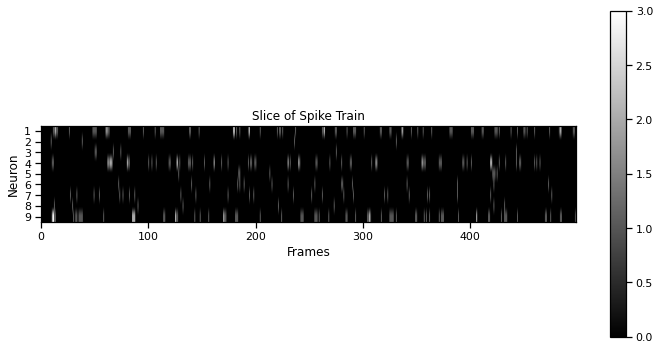

In [ ]:
# Plot a few seconds of the spike train
def plot_spike_train(spikes, t_start, t_stop, figsize=(12, 6)):
    """
    `imshow` a window of the spike count matrix.

    spikes:  time x neuron spike count matrix
    t_start: time (in seconds) of the start of the window
    t_stop:  time (in seconds) of the end of the window
    figsize: width and height of the figure in inches
    """
    plt.figure(figsize=figsize)

    ###
    # YOUR CODE BELOW
    #
    print(spikes[t_start*frame_rate:t_stop*frame_rate,:].shape)
    plt.imshow(spikes[t_start*frame_rate:t_stop*frame_rate,:].T,
               aspect=10,
               cmap='gray')
    plt.colorbar()
    plt.title('Slice of Spike Train')
    plt.ylabel('Neuron')
    plt.xlabel('Frames')
    plt.yticks(ticks=np.arange(0, 9),
               labels=np.arange(1, 10))
    #
    ###

plot_spike_train(spikes, 0, 5)

## Problem 1b: Compute the baseline firing rate for each neuron

Print the mean firing rate for each neuron (on the training data) in spikes per second.

In [ ]:
###
# Compute the firing rates
# YOUR CODE BELOW
#
print("Mean firing rates:")
for n in range(num_neurons):
    print("  neuron {}: {:.4f} spk/sec".format(n, 
                                               np.mean(spikes[:,n])*frame_rate))
#
###

Mean firing rates:
  neuron 0: 7.1598 spk/sec
  neuron 1: 1.9219 spk/sec
  neuron 2: 1.9822 spk/sec
  neuron 3: 6.2960 spk/sec
  neuron 4: 1.4038 spk/sec
  neuron 5: 1.3310 spk/sec
  neuron 6: 1.8496 spk/sec
  neuron 7: 0.4672 spk/sec
  neuron 8: 3.7988 spk/sec


## Plot a few frames of the stimulus

Plot the 0th, 10th, 20th, and 30th frames of stimulus in grayscale.

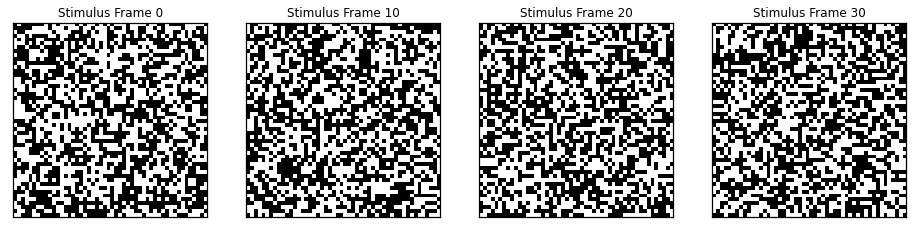

In [ ]:
# Plot a few frames of stimulus
def plot_stimulus(stimulus, frame_inds, n_cols=4, panel_size=4):
    num_frames = len(frame_inds)
    n_rows = int(np.ceil(num_frames / n_cols))
    fig, axs = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * panel_size, n_rows * panel_size))
    for ax, ind in zip(axs.ravel(), frame_inds):
        ax.imshow(stimulus[ind], cmap="Greys")
        ax.set_title("Stimulus Frame {}".format(ind))
        ax.set_xticks([])
        ax.set_yticks([])
    for ax in axs.ravel()[len(frame_inds):]:
        ax.set_visible(False)
    
plot_stimulus(stimulus, [0, 10, 20, 30])


## Problem 1c: Compute and plot the spike triggered average

The spike triggered average for neuron $n$ is the average stimulus in the lead-up to a spike by that neuron.

Formally, let $A_n \in \mathbb{R}^{D \times P_H \times P_W}$ denote the STA for neuron $n$. It's defined as,
\begin{align}
A_{n,d,i,j} = \frac{1}{S_{n,d}} \sum_{t=d+1}^T x_{t-d,i,j} \mathbb{I}[y_{t,n} >0]
\end{align}
where $S_{n,d} = \sum_{t=d+1}^T \mathbb{I}[y_{t,n} >0]$ is the number of spikes on neuron $n$, accounting for edge effects. 

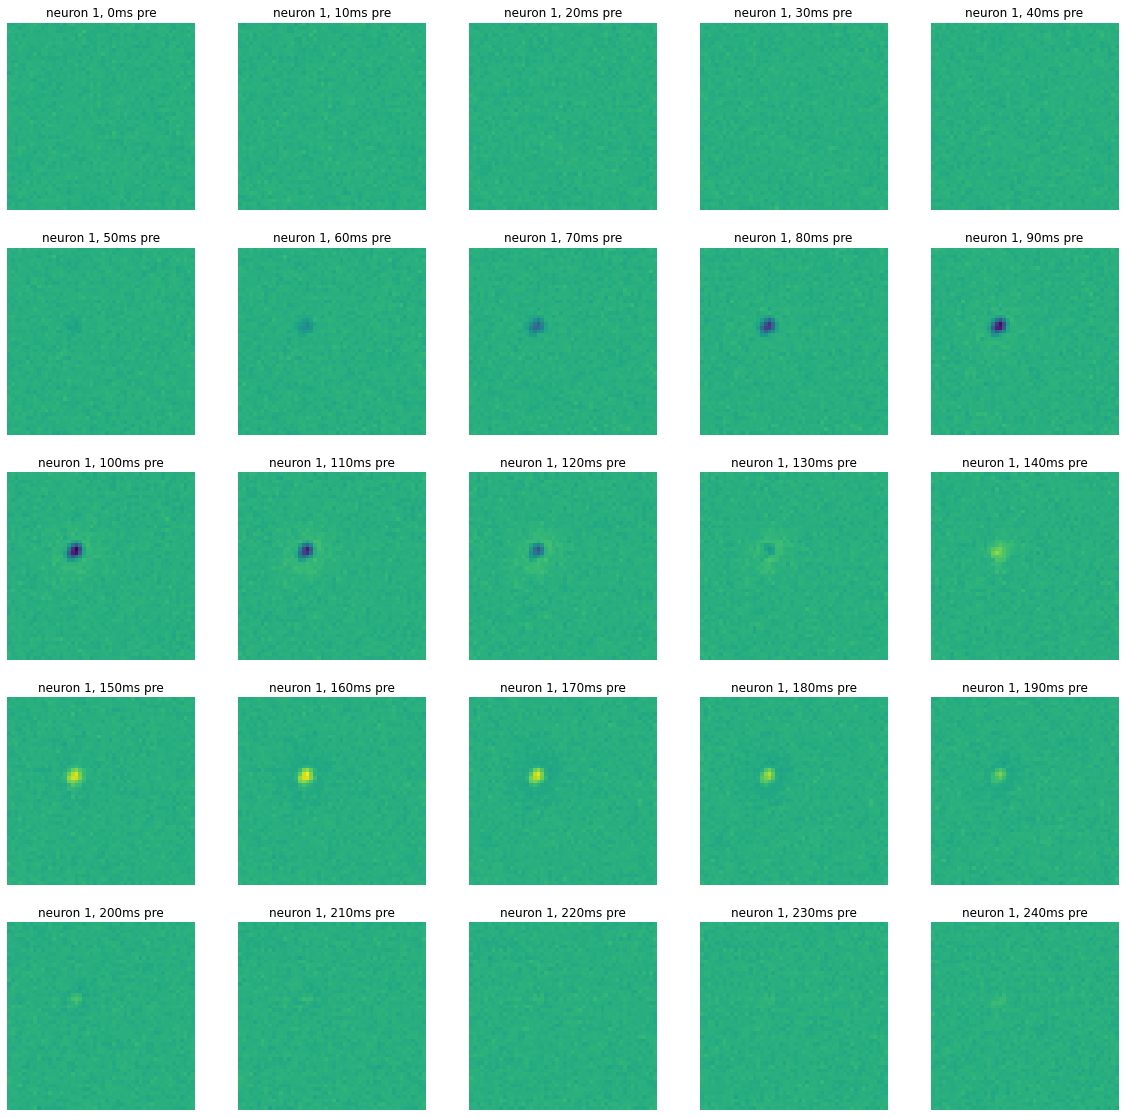

In [ ]:
def compute_sta(neuron, stimulus, spikes, max_delay=25):
    """
    Compute the spike triggered average.

    neuron: int index of the neuron 
    stimulus: (frames x height x width) array of stimulus
    spikes: (frames x neurons) array of spike counts
    max_delay: number of preceding frames (D) in the STA

    returns: max_delay x height x width STA
    """
    ###
    # YOUR CODE BELOW
    #
    sta = []

    # should this indeed be 0 to max_delay (exclusive)?
    # plot function and Han's sanity check below seems to imply that yes
    for d in range(0, max_delay):
      Snd = np.sum(spikes[d:,neuron] > 0)

      # explicitly catch the case where we have no delay
      if d == 0:
        sta.append((1/Snd)*np.sum(stimulus[:,:,:]*
                                  (spikes[:,neuron] > 0).reshape(-1,1,1),
                                  axis=0)) 

      # otherwise, do what we were doing
      else:   
        sta.append((1/Snd)*np.sum(stimulus[:-d,:,:]*
                                  (spikes[d:,neuron] > 0).reshape(-1,1,1),
                                  axis=0))

    sta = np.asarray(sta)
    #
    ###
    return sta

def plot_sta(neuron, sta, n_cols=5):
    max_delay = sta.shape[0]
    n_rows = int(np.ceil(max_delay / n_cols))

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_rows, 4 * n_cols))
    vmin = sta.min()
    vmax = sta.max()
    for d, ax in enumerate(axs.ravel()):
        ax.imshow(sta[d], vmin=vmin, vmax=vmax)
        ax.set_axis_off()
        ax.set_title("neuron {}, {}ms pre".format(neuron + 1, d*10))
    for ax in axs.ravel()[max_delay:]:
        ax.set_visible(False)

n = 0
sta = compute_sta(n, stimulus, spikes)
plot_sta(n, sta)

In [ ]:
# sanity check from Han
assert np.allclose(sta[1, 1, 1], 63.834709)

## Finally, create PyTorch Datasets containing the stimuli and the spikes.
Before moving onto the modeling sections, we'll split the training stimulus and spikes into batches of length 1000 frames (10 seconds of data). Then we'll randomly assign 20% of the batches to a validation dataset. We've written a simple dataset to get the training and validation batches. For stability, we normalize the stimulus to be binary rather than 0 or 128, as in the raw data.

In [ ]:
  class RGCDataset(Dataset):
    def __init__(self, stimulus, spikes):
        self.stimulus = stimulus
        self.spikes = spikes

    def __len__(self):
        return self.stimulus.shape[0]

    def __getitem__(self, idx):
        # Binarize the stimulus, move it and the spikes to the GPU,
        # and package into a dictionary
        return dict(stimulus=to_t(self.stimulus[idx]) / 128.0, 
                    spikes=to_t(self.spikes[idx]))

def make_datasets(batch_size=1000):
    n_batches = num_frames // batch_size
    batched_stimulus = stimulus[:n_batches * batch_size]
    batched_stimulus = batched_stimulus.reshape(n_batches, batch_size, height, width)
    batched_spikes = spikes[:n_batches * batch_size]
    batched_spikes = batched_spikes.reshape(n_batches, batch_size, num_neurons)

    # Split into train and validation
    train_stimulus, val_stimulus, train_spikes, val_spikes = \
        train_test_split(batched_stimulus, 
                        batched_spikes, 
                        train_size=0.8, 
                        random_state=0)


    train_dataset = RGCDataset(train_stimulus, train_spikes)
    val_dataset = RGCDataset(val_stimulus, val_spikes)
    return train_dataset, val_dataset

train_dataset, val_dataset = make_datasets()

# Part 2: Fit a linear-nonlinear Poisson (LNP) model

<center>
<img src=https://github.com/slinderman/stats320/raw/main/assets/lnp.png width=500>
</center>
<small><it>Image credit: Jonathan Pillow, Cosyne Tutorial 2018.</it></small>

Let's start with a simple linear-nonlinear-Poisson (LNP) model. In statistics, we would just call this a generalized linear model (GLM), but here we'll stick to the neuroscience lingo to be consistent with McIntosh et al. (2016). LNP models (and GLMs more generally) are natural models for count data, like spike counts. Whereas standard linear models could ouput negative means, these models are constrained to output non-negative expected spike counts. Moreover, since they use a Poisson noise model, the variance of the spike counts will grow with the mean, unlike in typical linear regression models.

The basic LNP model is,
\begin{align}
\mathbb{E}[y_{tn} \mid X] 
&= f \left(\sum_{d=1}^D \sum_{i=1}^{P_H} \sum_{j=1}^{P_W} x_{t-d,i,j} w_{n,d,i,j} \right) \\
&= f \left( \sum_{d=1}^D v_{n,d} \left(\sum_{i=1}^{P_H} \sum_{j=1}^{P_W} x_{t-d,i,j} u_{n,i,j} \right) \right) \\
&= f \left( \sum_{d=1}^D v_{n,d} \tilde{x}_{n,t-d} \right) \\
&= f \left( [\tilde{x}_n \star v_n]_t \right)
\end{align}
where $w_{n,d,i,j} = v_{n,d} u_{n,i,j}$ is the weight neuron $n$ gives to the simulus at pixel $i,j$ at $d$ frames preceding the current time. The variable $\tilde{x}_{n} \in \mathbb{R}^T$ denotes the stimulus projected onto the spatial filter for neuron $n$, and $\left( \tilde{x}_n \star v_n \right)\in \mathbb{R}^T$ is the cross-correlation between the projected stimulus and the temporal filter. The mean function $f: \mathbb{R} \to \mathbb{R}_+$ maps the output of the linear filter to a non-negative expected spike count.

Once we compute $\mathbb{E}[y_{tn} \mid X]$ we compute the likelihood function based on a Poisson regression model:
\begin{align}
\log p(y_{tn} \mid X; W_n) &= \log \mathrm{Po}(y_{tn} \mid f \left( [\tilde{x}_n \star v_n]_t \right))
\end{align}

Summing across samples in $t$ leads to the full likelihood for estimating the parameters for a given neuron. We can do this simultaneously across all neurons by summing over $n$ too, as gradient descent will independently update each neuron's parameters.


## Problem 2a: Implement the model

Let's start by implementing the GLM model as a class that inherits from `nn.Module`. The  `forward` method returns the mean spike count for each time bin
given the stimulus. In the loss function below (Problem 2b), we'll pass this output to the mean of a Poisson distribution.

**Notes:**
- As in Lab 2, you should first project the stimulus onto the spatial filters with a linear layer, then you can convolve with the temporal filters.
- Even though the spatial projection is a linear layer, we'll call it `spatial_conv` since its a factor of a spatiotemporal convolution. This naming will also be consistent with our models below.
- Both `spatial_conv` and `temporal_conv` include a learnable bias, by default. We only need one, so turn off the bias in the spatial layer.
- `mean_function` specifies the mapping from the linear predictor to the expected spike count. We'll use an exponential function to be consistent with the lecture, but `F.softplus` is more common in practice. (It tends to be a little more stable during training.
- We set the initial bias to a value that is roughly the log of the average spike count so that our initial means are in the right ballpark.
- We'll add a small positive constant to the firing rate in the `forward` function to ensure that we don't get `log(0)` errors during training.
- `forward` takes a keyword argument `spikes`. We won't use it in this model, but we need it here so that our training algorithm will work for this model as well as the later ones.

In [ ]:
class LNP(nn.Module):
    def __init__(self,
                 num_neurons=num_neurons,
                 height=height,
                 width=width,
                 max_delay=40,
                 mean_function=torch.exp,
                 initial_bias=0.05):
        super(LNP, self).__init__()
        self.num_neurons = num_neurons
        self.height = height
        self.width = width
        self.max_delay = max_delay
        self.mean_function = mean_function

        ###
        # YOUR CODE BELOW
        #

        # T x Pixels --> T x Neurons
        self.spatial_conv = nn.Linear(self.height * self.width,
                                      self.num_neurons,
                                      bias=False) 
        # Filter over time dim (TxN)
        self.temporal_conv = nn.Conv1d(in_channels=self.num_neurons,
                                       out_channels=self.num_neurons,
                                       kernel_size=max_delay,
                                       padding=max_delay-1,
                                       groups=self.num_neurons) 

        #
        ###

        # Initialize the bias
        torch.nn.init.constant_(self.temporal_conv.bias, np.log(initial_bias))

    def forward(self, stimulus, spikes=None):
        """
        stimulus: num_frames x height x width
        spikes: num_frames x num_neurons (unused by this model)
        
        returns: num_frames x num_neurons tensor of expected spike counts
        """
        ###
        # YOUR CODE BELOW
        #
        
        x = stimulus

        T, H, W = x.shape

        # flatten over H, W so we can apply linear layer (spatial_conv)
        x = x.flatten(1)
        x = self.spatial_conv(x)

        # rearrange (TxN) ==> (1xNxT) so we do the conv over time
        x = x.T.unsqueeze(0)
        x = self.temporal_conv(x)[:, :, :T]

        # transpose back to (TxN)
        x = x.squeeze(0).T
        x = self.mean_function(x)
        #
        ###
        return 1e-4 + x


def check_model_outputs(model):
    out_t = model(train_dataset[0]['stimulus'],
                  train_dataset[0]['spikes'])
    assert out_t.shape == train_dataset[0]['spikes'].shape
    assert torch.all(out_t > 0)

# Construct an LNP model with random initial weights.
# Fix the seed so that the tests below will work
torch.manual_seed(0)
lnp = LNP().to(device)
check_model_outputs(lnp)

## Problem 2b: Implement the Poisson loss
Compute the average negative log likelihood of the spikes (taking the mean over neurons and frames) given the expected spike counts (`rates_t`) ouput by the model. 

\begin{align}
\mathcal{L}(W) = -\frac{1}{NT} \sum_{n=1}^N \sum_{t=1}^T \log \mathrm{Po}(y_{nt} \mid \lambda_{ntt})
\end{align}
where $\lambda_{nt} = f([X \star W_n]_t)$ denotes the rates output by the model.

In [ ]:
def poisson_loss(rate_t, spikes_t):
    """Compute the log-likelihood under a Poisson spiking model.

    rate_t:  T x N array of expected spike counts
    spikes_t: T x N array of integer spikes
    returns: average negative log likelihood (mean over all spikes)
    """
    ###
    # YOUR CODE BELOW

    # use log prob from torch.distribution library
    # saied got 2e-4 error (0.1317)
    # isabel used torch.mean and that fixed something
    # make sure your temp conv has groups defined

    avg_nll = -torch.distributions.Poisson(rate=rate_t).log_prob(spikes_t).mean()
    ###
    return avg_nll
    

loss = poisson_loss(lnp(train_dataset[0]['stimulus']), 
                 train_dataset[0]['spikes'])
print(loss)

assert torch.isclose(
    poisson_loss(lnp(train_dataset[0]['stimulus']), 
                 train_dataset[0]['spikes']),
    torch.tensor(0.1319), atol=1e-4)

tensor(0.1319, device='cuda:0', grad_fn=<NegBackward>)


## Problem 2c: Important simple $\ell_2$ weight regularization

To the Poisson loss above, we'll add a regularization penalty on the squared $\ell_2$ norm of the weights,
\begin{align}
\mathcal{R}(W_n) &= \frac{\alpha}{2} (\|U_n\|_F^2 + \|V_n\|_F^2)
\end{align}
where $U_n$ and $V_n$ are the spatial and temporal weights, respectively, and $\alpha$ is a scaling factor.

Do not regularize the biases.


In [ ]:
def lnp_regularizer(model, alpha=1e-3):
    """Compute the log prior probability under a mean-zero Gaussian model.

    model: LNP instance
    scale: standard deviation 
    returns: scalar sum of log probabilities for each spike.
    """
    ###
    # YOUR CODE BELOW
    reg = (alpha / 2) * (torch.norm(model.spatial_conv.weight)**2 +
                         torch.norm(model.temporal_conv.weight)**2)
    #
    ###
    return reg

## Fit the LNP model

In [ ]:
# Construct an LNP model with random initial weights.
torch.manual_seed(0)
lnp = LNP().to(device)

# Fit the LNP model
print("Training LNP model. This should take about 3-4 minutes...")
train_losses, val_losses = \
    train_model(lnp, 
                train_dataset, 
                val_dataset, 
                poisson_loss,
                lnp_regularizer)


Training LNP model. This should take about 3-4 minutes...


## Plot the results

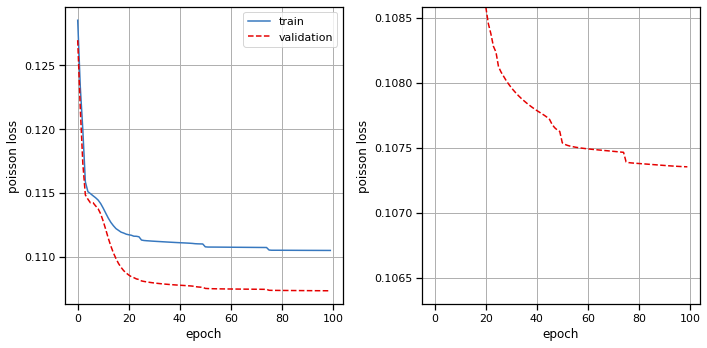

In [ ]:
# Plot the training and validation curves
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(train_losses, color=palette[0], label="train")
axs[0].plot(val_losses, color=palette[1], ls='--', label="validation")
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("poisson loss")
axs[0].grid(True)
axs[0].legend(loc="upper right")

axs[1].plot(train_losses, color=palette[0], label="train")
axs[1].plot(val_losses, color=palette[1], ls='--', label="validation")
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("poisson loss")
axs[1].set_ylim(top=val_losses[20])
axs[1].grid(True)

plt.tight_layout()

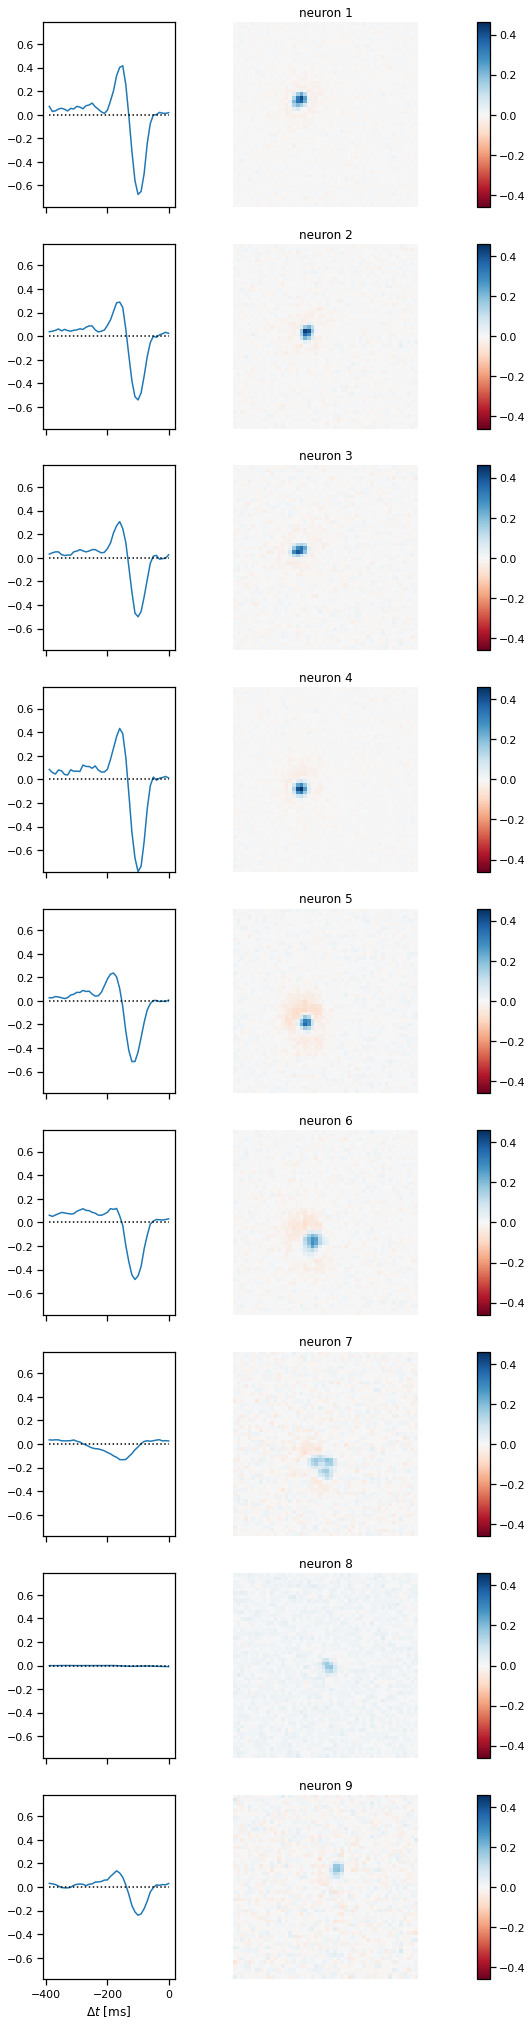

In [ ]:
plot_stimulus_weights(lnp)

## Problem 2d: [Short Answer] Interpret the results

Describe the outputs of the LNP model. Are they what you expected? How do the spatiotemporal filters relate to the STA from Problem 1c? Are they mathematically related?

_Answer below this line_

---

The results appear to be what we would expect: the spatial component looks localized around a certain point corresponding to a given neuron's stimulus and the temporal component varies in a manner similar to what we observed with the STA: the stimulus value changes sign prior to a measured spike.

The spatiotemporal filters can be interpreted as something similar to the STA from Problem 1c: if we multiply the spatial component by the value from the temporal component across time, we would expect to get something similar to the STA: average stimulus prior to a spike. The STA from 1c is derived from the true spikes, while our model weights are effectively trying to learn that average response profile.

# Part 3: Fit a GLM with inter-neuron couplings

<center>
<img src=https://github.com/slinderman/stats320/raw/main/assets/glm.png width=300>
</center>
<small><it>Image credit: Jonathan Pillow, Cosyne Tutorial 2018.</it></small>

Now add inter-neuron couplings to the basic model above. For historical reasons, the LNP with inter-neuron couplings is what some neuroscientists call a GLM, even though they're both instances of generalized linear models! Again, we're just going to stick to the notation of McIntosh et al (2016) for this lab anyway.  

The new model is,

\begin{align}
\mathbb{E}[y_{nt}] 
&= f \left( \tilde{x}_n \star v_n +  \sum_{m=1}^N \sum_{d=1}^D y_{m,t-d} g_{m,n,d} \right)
\end{align}
where $G \in \mathbb{R}^{N \times N \times D}$ is a weight matrix of self-couplings.

Recall from lecture that you can implement the couplings as a convolution of $Y$ and $G$. 

**Note:** as above, the `coupling_conv` will have a bias by default. Get rid of it. You don't need it since there's already a bias in the `temporal_conv`.

**IMPORTANT:** Make sure your output only depends on spike counts up to but _not including_ time $t$!!

## Problem 3a: Implement the coupled model

In [ ]:
class GLM(nn.Module):
    def __init__(self,
                 num_neurons=num_neurons,
                 height=height,
                 width=width,
                 max_delay=40,
                 initial_bias=0.05,
                 mean_function=torch.exp):
        super(GLM, self).__init__()
        self.num_neurons = num_neurons
        self.height = height
        self.width = width
        self.max_delay = max_delay
        self.mean_function = mean_function

        ###
        # YOUR CODE BELOW
        #

        # T x Pixels --> T x Neurons
        self.spatial_conv = nn.Linear(self.height * self.width,
                                      self.num_neurons,
                                      bias=False) 
        # Filter over time dim (TxN)
        self.temporal_conv = nn.Conv1d(in_channels=self.num_neurons,
                                       out_channels=self.num_neurons,
                                       kernel_size=max_delay,
                                       padding=max_delay-1,
                                       groups=self.num_neurons) 
        
        # Coupling conv needs extra padding to ensure causality
        # i.e. we are NOT including spiking at time T which we 
        # want to predict
        self.coupling_conv = nn.Conv1d(in_channels=self.num_neurons,
                                       out_channels=self.num_neurons,
                                       kernel_size=self.num_neurons,
                                       padding=max_delay, # note: extra padding 
                                       bias=False)

        #
        ###

        # Initialize the bias
        torch.nn.init.constant_(self.temporal_conv.bias, np.log(initial_bias))

    def forward(self, stimulus, spikes):
        """
        stimulus: num_frames x height x width
        spikes: num_frames x num_neurons (unused by this model)
        
        returns: num_frames x num_neurons tensor of expected spike counts
        """
        ###
        # YOUR CODE BELOW
        #
        x, y = stimulus, spikes
        
        T, H, W = x.shape

        # flatten over H, W so we can apply linear layer (spatial_conv)
        x = x.flatten(1)
        x = self.spatial_conv(x)

        # rearrange (TxN) ==> (NxT) so we do the conv over time
        x = x.T.unsqueeze(0)
        x = self.temporal_conv(x)[:, :, :T]
        
        # transpose back to (TxN)
        x = x.squeeze(0).T

        # coupling conv uses spikes
        y = y.T.unsqueeze(0)
        y = self.coupling_conv(y)[:, :, :T]
        y = y.squeeze(0).T

        x = self.mean_function(x + y)
        #
        ###

        #
        ###
        return 1e-4 + x

# Construct a coupled GLM model with random initial weights.
torch.manual_seed(0)
glm = GLM(num_neurons=9).to(device)
check_model_outputs(glm)

## Problem 3b: Implement a regularizer for the coupled GLM weights

Put an $\ell_2$ (squared $\ell_2$) penalty on the weights of the `spatial_conv`, `temporal_conv`, and `coupling_conv`. No need to regularize the bias. Scale the regularization by $\alpha$.

In [ ]:
def glm_regularizer(model, alpha=1e-3):
    """Compute the log prior probability under a mean-zero Gaussian model.

    model: LNP instance
    scale: standard deviation 
    returns: scalar sum of log probabilities for each spike.
    """
    ###
    # YOUR CODE BELOW
    reg = (alpha / 2) * (torch.norm(model.spatial_conv.weight)**2 +
                         torch.norm(model.temporal_conv.weight)**2 +
                         torch.norm(model.coupling_conv.weight)**2)
    #
    ###
    return reg

## Fit the GLM model with couplings between neurons.

In [ ]:
# Construct a coupled GLM model with random initial weights.
torch.manual_seed(0)
glm = GLM().to(device)

# Fit the model
print("Training coupled GLM. This should take about 4 minutes...")
train_losses, val_losses = \
    train_model(glm, 
                train_dataset, 
                val_dataset, 
                poisson_loss,
                glm_regularizer)


Training coupled GLM. This should take about 4 minutes...


## Plot the results

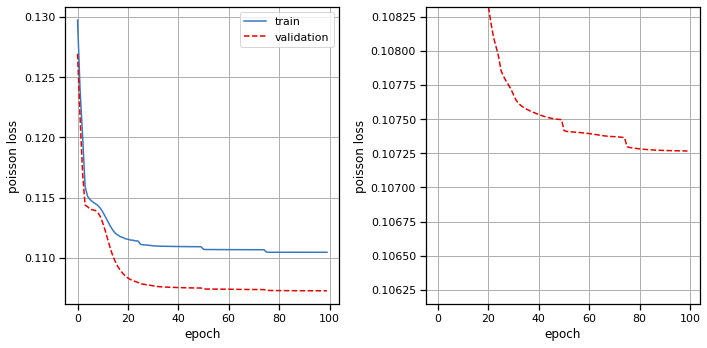

In [ ]:
# Plot the training and validation curves
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(train_losses, color=palette[0], label="train")
axs[0].plot(val_losses, color=palette[1], ls='--', label="validation")
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("poisson loss")
axs[0].grid(True)
axs[0].legend(loc="upper right")

axs[1].plot(train_losses, color=palette[0], label="train")
axs[1].plot(val_losses, color=palette[1], ls='--', label="validation")
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("poisson loss")
axs[1].set_ylim(top=val_losses[20])
axs[1].grid(True)

plt.tight_layout()

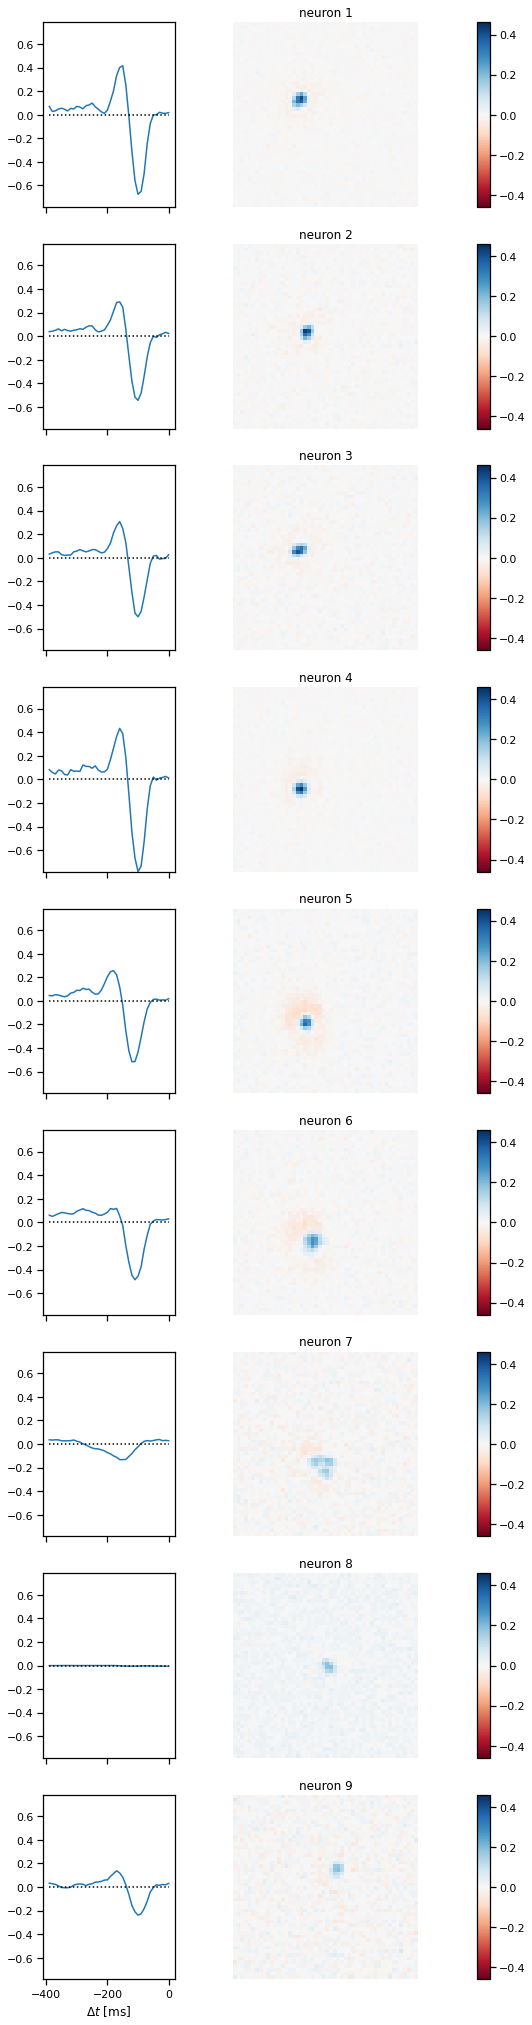

In [ ]:
plot_stimulus_weights(glm)

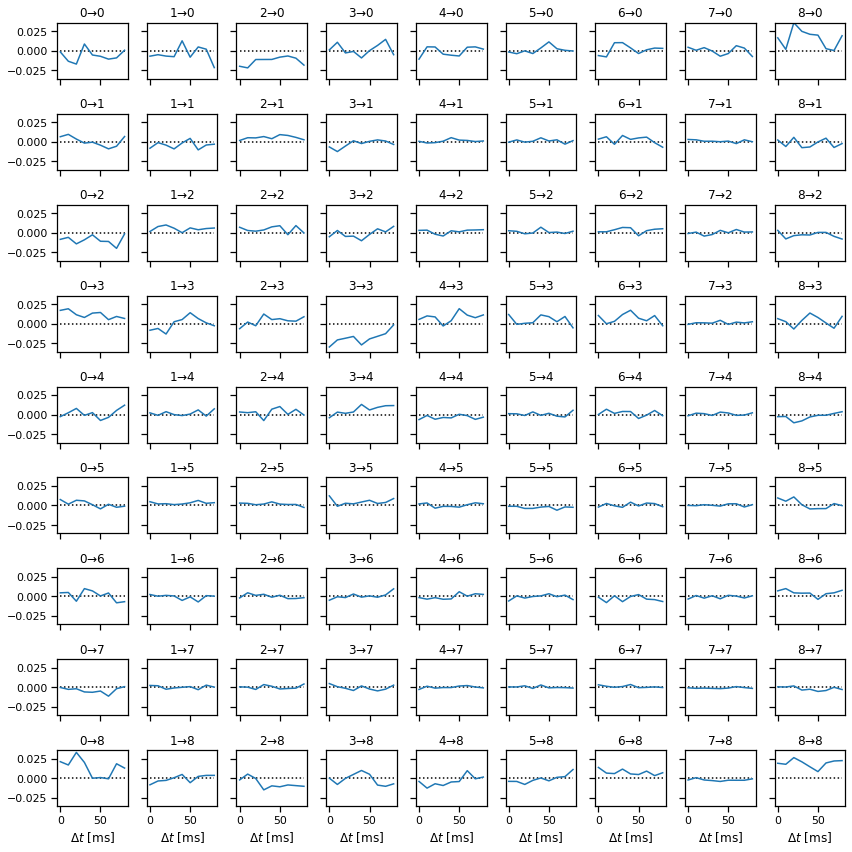

In [ ]:
plot_coupling_weights(glm)

## Problem 3c: [Short Answer] Interpret the results

Did adding the coupling weights change the spatiotemporal stimulus filters in any perceptible way? Do you see any interesting structure in the coupling weights? What other regularization strategies could you have applied to the coupling weights?

_Answer below this line_

---

The coupling weights did not change in any perceptible way (we can see slight variations in the temporal weights for neuron 5, however it is very minor). One notable observation of the coupling weights is that most interaction terms are close to zero. This is likely due to the fact that we used L2-regularization on the weights. Additionally, here we use bins of length 10ms (compared to the Pillow et al. paper which uses 1ms bins), so if neuron-neuron coupling occurs at shorter time intervals we would not pick that up in our model.

Other regularization strategies we could have used would be L1-regularization or applying different penalties (multiple $\alpha$'s) to the different weights.

# Part 4: Convolutional neural network model

<center>
<img src=https://github.com/slinderman/stats320/raw/main/assets/cnn.png width=500>
</center>
<small><it>Image credit: McIntosh et al (NeurIPS, 2016).</it></small>

Finally, we'll implement a convolutional neural network like the one proposed in McIntosh et al (2016). (See above.) We'll make some slight modifications though, so that the model doesn't take so long to fit.


## Problem 4a: Implement the convolutional model

Implement the following model:
1. **Apply a rank-1 spatiotemporal filter to the video:**
  
  a. First convolve with 2D receptive fields of size `rf_size_1` and `num_subunits_1` output channels. You do not need to pad the edges since the neurons respond primarily to the center of the video. Your output should be `T x N1 x H1 x W1` where `T` is the number of frames, `N1` is the number of subunits, and `H1,W1` are the height and width after 2D convolution without padding.
  
  b. Then convolve each subunit and pixel with a temporal filter, to get another `T x N1 x H1 x W1` output.

  c. Apply a rectifying nonlinearity (`F.relu`).

2. **Spatial convolution and mixing**

  a. Apply a spatial convolution of size `rf_size_2` with `num_subunits_2` output channels. This layer mixes the subunits from the first layer to obtain a representation that is, hopefully, somewhat similar to that of intermediate cells in the retina. 
  
  b. Apply another rectifying nonlinearity (`F.relu`). The output should be `T x N2 x H2 x W2` where `N2` is the number of subunits in the second layer and `H2,W2` are the size of the image after convolution without padding.

3. **Predict expected spike counts**

  a. Apply a linear read-out to the `N2 x H2 x W2` representation and pass through the mean function to obtain a `T x N` tensor of expected spike counts, where `N` is the number of neurons.


**Notes:** The modifications we made are
- We used slightly larger receptive field sizes. This actually speeds things up since, with valid padding, we end up with fewer "pixels" in subsequent layers.
- We used a smaller number of subunits (4/4 as opposed to 8/16). This is a smaller dataset (only 9 neurons) and we seemed to overfit with more layers. 
- We use an exponential mean function to be consistent with the models above. Again, a softplus is more common in practice.

In [ ]:
class CNN(nn.Module):
    def __init__(self,
                 num_neurons=num_neurons,
                 height=height,
                 width=width,
                 rf_size_1=21,
                 rf_size_2=15,
                 max_delay=40,
                 num_subunits_1=4,
                 num_subunits_2=4,
                 initial_bias=0.05,
                 mean_function=torch.exp):
        
        super(CNN, self).__init__()
        self.num_neurons = num_neurons
        self.height = height
        self.width = width
        self.max_delay = max_delay
        self.rf_size_1 = rf_size_1
        self.num_subunits_1 = num_subunits_1
        self.rf_size_2 = rf_size_2
        self.num_subunits_2 = num_subunits_2
        self.mean_function = mean_function
        
        ###
        # YOUR CODE BELOW
        #
        self.spatial_conv = nn.Conv2d(in_channels=1,
                                      out_channels=self.num_subunits_1,
                                      kernel_size=self.rf_size_1)
        self.temporal_conv = nn.Conv1d(in_channels=30*30*4,
                                       out_channels=30*30*4,
                                       kernel_size=self.max_delay,
                                       padding=self.max_delay-1,
                                       groups=30*30*4)
        
        # Spatial convolution over the subunits in layer 1
        self.layer2 = nn.Conv2d(in_channels=self.num_subunits_1,
                                out_channels=self.num_subunits_2,
                                kernel_size=self.rf_size_2)
        
        # Fully connected layer at the end
        self.layer3 = nn.Linear(4*16*16, self.num_neurons)
        #
        ###

        # Initialize the bias
        torch.nn.init.constant_(self.layer3.bias, np.log(initial_bias))
        
    def forward(self, stimulus, spikes=None):
        """
        stimulus: num_frames x height x width
        spikes: num_frames x num_neurons (unused by this model)
        
        returns: num_frames x num_neurons tensor of expected spike counts
        """
        ###
        # YOUR CODE BELOW
        #
        x = stimulus

        # step 1
        T, H, W = stimulus.shape

        x = x.unsqueeze(1)
        x = self.spatial_conv(x)

        og_shape = x.shape
        x = x.flatten(1).T.unsqueeze(0)
        x = self.temporal_conv(x)[:, :, :T]
        x = x.squeeze(0).T.view(og_shape)
        x = F.relu(x)

        # step 2
        x = self.layer2(x)
        x = F.relu(x)

        # step 3
        x = x.flatten(1)
        x = self.layer3(x)
        x = self.mean_function(x)

        #
        ###
        return 1e-4 + x


torch.manual_seed(0)
cnn = CNN().to(device)
check_model_outputs(cnn)


## Problem 4b: Regularize the weights

Put an $\ell_2$ penalty on the weights of `spatial_conv`, `temporal_conv`, `layer2`, and `layer3`. Scale the regularize by $\alpha$, as in the preceding sections. No need to regularize the biases. We found that a smaller value of $\alpha$ was helpful, so here we default to `1e-5`. 

In [ ]:
# Regularize the weights of the CNN
def cnn_regularizer(model, alpha=1e-5):
    """A regularizer on the squared 2-norm of the weights

    model: CNN instance
    scale: standard deviation 
    returns: scalar sum of log probabilities for each spike.
    """
    ###
    # YOUR CODE BELOW
    reg = (alpha / 2) * (torch.norm(model.spatial_conv.weight)**2 +
                         torch.norm(model.temporal_conv.weight)**2 +
                         torch.norm(model.layer2.weight)**2 + 
                         torch.norm(model.layer3.weight)**2)
    #
    ###
    return reg

## Fit the CNN model

In [ ]:
torch.manual_seed(0)
cnn = CNN().to(device)

print("Fitting the CNN model. This should take about 12 minutes.")
train_losses, val_losses = \
    train_model(cnn, 
                train_dataset, 
                val_dataset,
                poisson_loss,
                cnn_regularizer)


Fitting the CNN model. This should take about 12 minutes.


## Plot the results

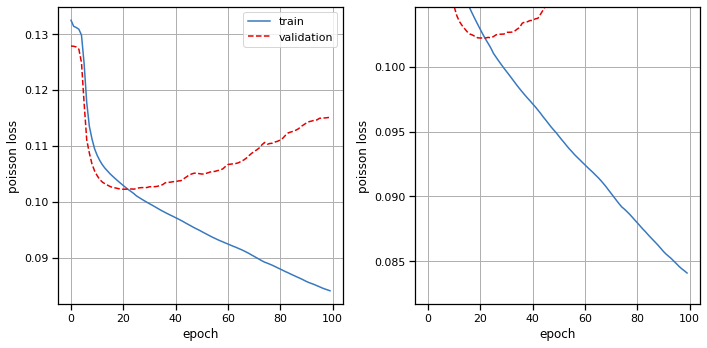

In [ ]:
# Plot the training and validation curves
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(train_losses, color=palette[0], label="train")
axs[0].plot(val_losses, color=palette[1], ls='--', label="validation")
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("poisson loss")
axs[0].grid(True)
axs[0].legend(loc="upper right")

axs[1].plot(train_losses, color=palette[0], label="train")
axs[1].plot(val_losses, color=palette[1], ls='--', label="validation")
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("poisson loss")
axs[1].set_ylim(top=val_losses[10])
axs[1].grid(True)

plt.tight_layout()

## Plot the subunit weights for the CNN

First we'll plot the spatiotemporal filters of the first layer of subunits.

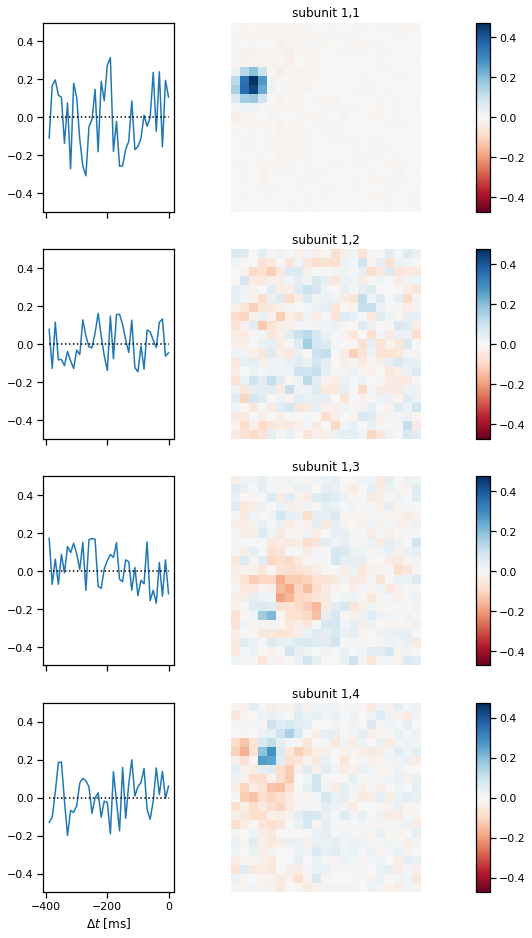

In [ ]:
plot_cnn_subunits_1(cnn)

## Plot the spatial weights for the second layer of subunits.

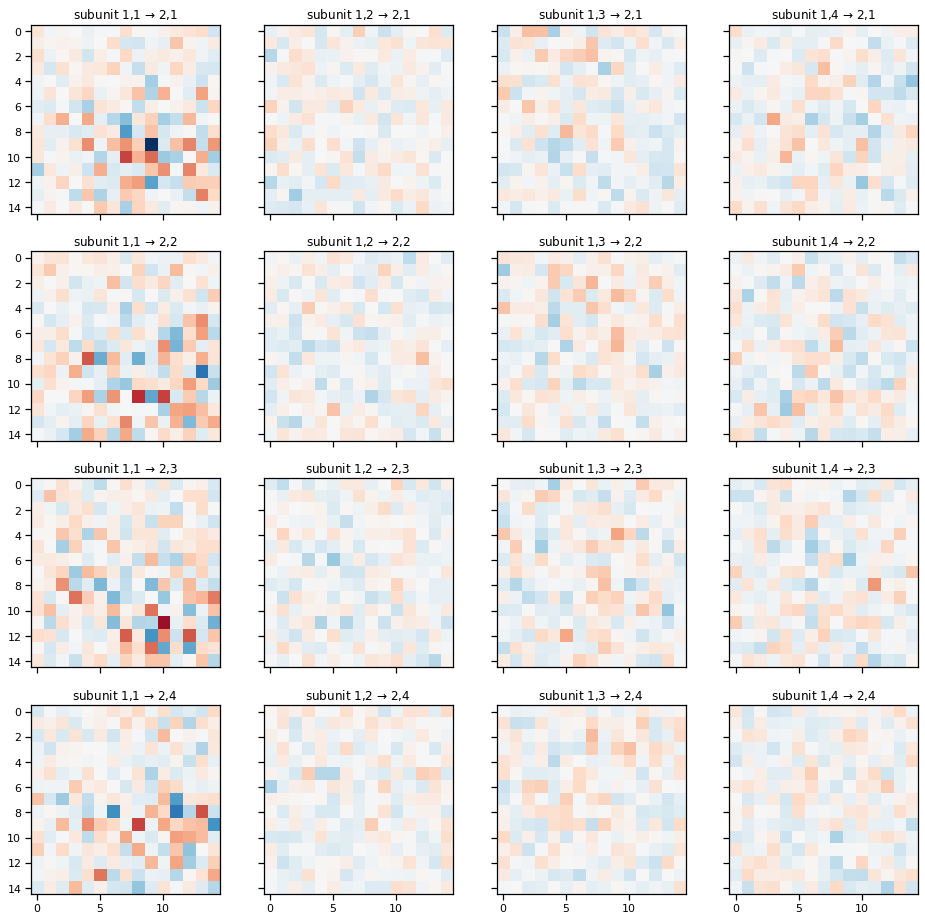

In [ ]:
plot_cnn_subunits2(cnn)

## Problem 4c: Predict test firing rates

Finally, take the fitted models from Parts 2-4 and evaluate them on test data. 

The test data consists of _expected_ spike counts rather than spike counts. That's because they showed the same visual stimulus many times and computed the average response.  If our models are working well, they should output a similar firing rate in response to that same visual stimulus. 

Compute the predicted rates given the test stimulus using the LNP, GLM, and the CNN. Then plot them for a slice of the test data alongside the true test rates

**Note:** technically the coupled GLM from Part 3 expects preceding spikes as input, but here we'll give it the rates as input instead. (We don't have test spikes to feed in.)

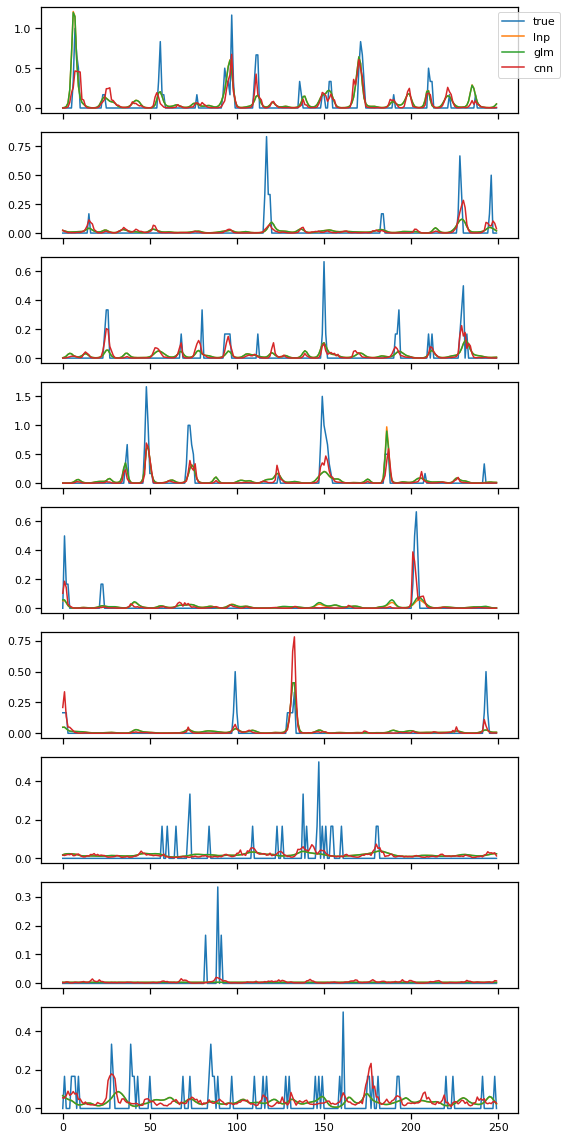

In [ ]:
# Move the test stimulus and measured rates to the GPU
test_stimulus_t = to_t(test_stimulus)
test_rates_t = to_t(test_rates)

###
# YOUR CODE BELOW
#
lnp_test_rates = lnp(test_stimulus_t).cpu().detach().numpy()
glm_test_rates = glm(test_stimulus_t, test_rates_t).cpu().detach().numpy()
cnn_test_rates = cnn(test_stimulus_t).cpu().detach().numpy()

# Plot a slice of the true and predicted firing rates
slc = slice(250, 500)
fig, axs = plt.subplots(num_neurons, 1, figsize=(8, 16), sharex=True)
for n in range(num_neurons):
    axs[n].plot(test_rates[slc, n], label="true")
    axs[n].plot(lnp_test_rates[slc, n], label="lnp")
    axs[n].plot(glm_test_rates[slc, n], label="glm")
    axs[n].plot(cnn_test_rates[slc, n], label="cnn")
axs[0].legend(bbox_to_anchor=(1.10, 1), loc='upper right')
#
###

plt.tight_layout()

## Problem 4d: Model comparison

Make a bar plot of the mean squared error between the true and predicted rates for each model. As a baseline, compute the mean squared error of a constant-rate model with rate equal to the expected spike count under the training data.


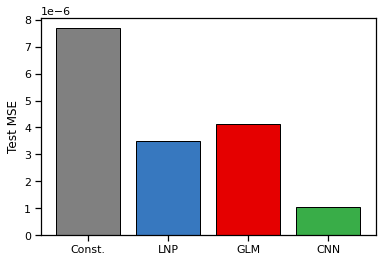

In [ ]:
###
# YOUR CODE BELOW
#
def mse(x, y):
  return np.square(np.mean(x - y))

mse_const = mse(test_rates, np.mean(spikes, axis=0))
mse_lnp = mse(test_rates, lnp_test_rates)
mse_glm = mse(test_rates, glm_test_rates)
mse_cnn = mse(test_rates, cnn_test_rates)
#
###

# Make a bar plot
plt.bar(0, mse_const, color='gray', ec='k')
plt.bar(1, mse_lnp, color=palette[0], ec='k')
plt.bar(2, mse_glm, color=palette[1], ec='k')
plt.bar(3, mse_cnn, color=palette[2], ec='k')
plt.xticks([0, 1, 2, 3], ["Const.", "LNP", "GLM", "CNN"])
plt.ylabel("Test MSE")
plt.show()

In [ ]:
# Get dispersion of different neurons in training data
np.var(spikes, axis=0) / np.mean(spikes, axis=0)

array([1.09532127, 0.99061479, 1.01326828, 1.14981572, 0.99665268,
       0.99003089, 0.98240529, 0.99532799, 1.19364838])

# Part 5: Discussion

You've now developed and fit three encoding models for these retinal ganglion cell responses, and hopefully you've developed some intuition for how these models work!

Let's end by discussing some of the decisions that go into building and checking these models. Write a few paragraphs summarizing your key takeaways. Here are a few suggestions of things to consider:

1. All three models were fit with a Poisson loss. What other loss functions could we use? What is overdispersion of count data? Is this an issue here?

2. The CNN was loosely motivated as an approximation to the layers of photoreceptors, bipolar cells, etc. that precede retinal ganglion cells. Of course, the actual circuitry is more complicated. What could you imagine adding to this model to make it more realistic?

3. In our hands, the CNN outperformed the LNP and GLM. Though it's tempting to just say the CNN is a more flexible model, notice that the CNN does not have coupling filters and it compresses the input substantially before the final read-out layer. Given the results above, what follow-up experiments would you do to further understand the root of these performance differences?

4. We didn't ask you to do a thorough hyperparameter search. If you were to do one, what are the key parameters you would vary to try to improve model performance?

5. We fit all of these models to RGC responses to a binary white noise stimulus. Would you expect your results to change if the cells had been shown a movie with natural scenes instead?

_Answer below this line_

---

1. Another loss function we could use is that from the negative binomial likelihood or a quasi-Poisson loss. Dispersion of count data is the ratio of the variance to the mean--overdispersion thus refers to data wherein the variance is greater than the mean. In a Poisson distribution, the variance is equal to the mean (unit dispersion), so if that assumption does not hold the model would not be as effective. For most neurons, the dispersion is close to 1 as desired; however, for neurons 0, 3, and 8 (zero-indexed) the dispersion is greater than 1 so the Poisson assumption might be problematic in some cases.

```python
# print dispersion per neuron for training spike data
np.var(spikes, axis=0) / np.mean(spikes, axis=0)
==>
array([1.09532127,
       0.99061479,
       1.01326828,
       1.14981572,
       0.99665268,
       0.99003089,
       0.98240529,
       0.99532799,
       1.19364838])
```

2. We could add more layers to the model in accordance with the number of layers we see in the visual cortex. We could also try to match the general connection structure (e.g. same receptive field, possible skip connections between layers, etc.) If the visual cortex has recurrent connections, we could also add recurrent layers to feed-back information as it is processed.

3. We could vary the flexibility of the CNN model by modifying the hyperparameters or decreasing the number of layers. If we saw improved performance still, this would suggest that the CNN architecture is especially well-suited for this task. We could also try to perform inference on synthetic data where we know the neuron-neuron coupling structure. Comparing the performance of the GLM (with explict neuron-neuron coupling) and the CNN (with implicit neuron-neuron coupling just by the computational structure) would help inform how well the CNN can model those types of interactions.

4. For the CNN, the number of layers, the number of subunits, and the kernel sizes are important hyperparameters. For all models, the regularization parameter alpha is also a key hyperparameter.

5. Yes, we would expect our results to change. In natural scenes, we would expect there to be more correlation across time since there would be continuity in the scene. Similarly, with the visual structure of natural scenes (an object or a face, e.g.), we would expect there to be more correlations spatially. We would expect this added temporal and spatial structure to have a considerable effect.

# Submission Instructions


**Formatting:** check that your code does not exceed 80 characters in line width. You can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit. 

Download your notebook in .ipynb format and use the following commands to convert it to PDF. 

**Option 1 (best case): ipynb &rarr; pdf** Run the following command to convert to a PDF:
```
jupyter nbconvert --to pdf lab5_teamname.ipynb
```

Unfortunately, `nbconvert` sometimes crashes with long notebooks. If that happens, here are a few options:


**Option 2 (next best): ipynb &rarr; tex &rarr; pdf**:
```
jupyter nbconvert --to latex lab5_teamname.ipynb
pdflatex lab5_teamname.tex
```

**Option 3: ipynb &rarr; html &rarr; pdf**:
```
jupyter nbconvert --to html lab5_teamname.ipynb
# open lab5_teamname.html in browser and print to pdf
```

**Dependencies:**

- `nbconvert`: If you're using Anaconda for package management, 
```
conda install -c anaconda nbconvert
```
- `pdflatex`: It comes with standard TeX distributions like TeXLive, MacTex, etc. Alternatively, you can upload the .tex and supporting files to Overleaf (free with Stanford address) and use it to compile to pdf.

**Upload** your .ipynb and .pdf files to Gradescope. 

**Only one submission per team!**